| Name | Student ID | Task|
|------|------------|------|
|Brijalben Panchal| 500224776|cGAN model fine tuning|

*Taken assignment-4 as refrence to finetune the model

## Load Library

In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow_datasets as tfds
from keras.preprocessing import image
from matplotlib import gridspec
%matplotlib inline

2024-07-24 15:22:25.830249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 15:22:25.830347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 15:22:25.969358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load image dataset

In [2]:
def load_image(folder, img_size, batch_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        folder,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='int',
        shuffle=True
    )
    return dataset

In [3]:
root_folder = '/kaggle/input/faceexpressions/dataset'
img_size = 200
batch_size = 128
latent_dim = 100

In [4]:
# Load the dataset
dataset = load_image(root_folder, img_size, batch_size)

Found 15453 files belonging to 6 classes.


In [5]:
dataset.class_names

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [6]:
tag = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [7]:
tag.index('Ahegao')

0

In [8]:
# Create dictionary of target classes
label_dict = {0: 'Ahegao',1: 'Angry',2: 'Happy',3: 'Neutral',4: 'Sad',5: 'Surprise'}

### Display images

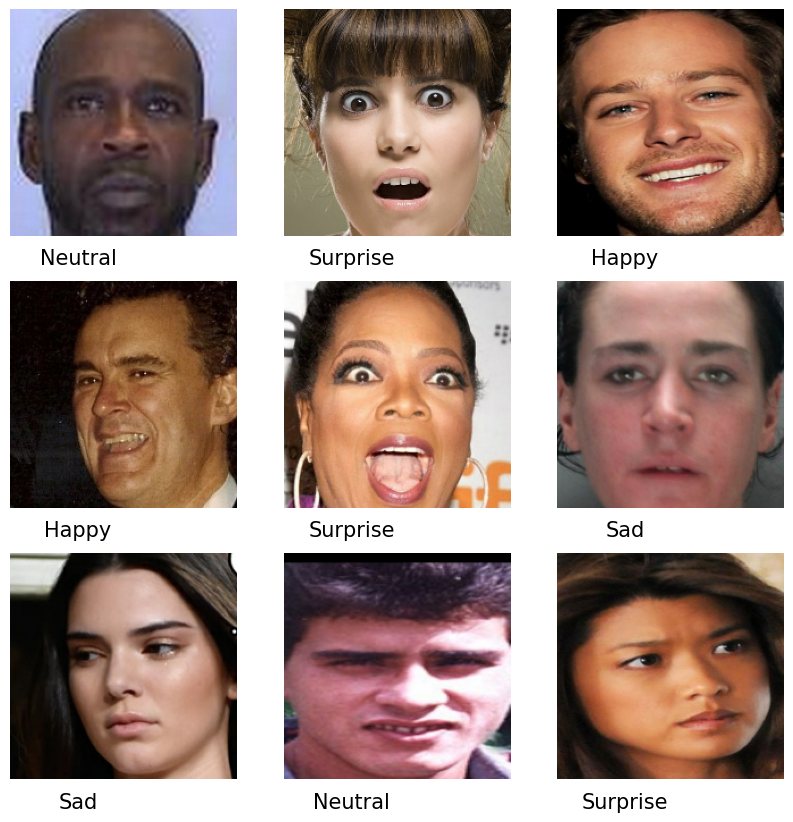

In [9]:
plt.figure(figsize=(10, 10))
for imge, label in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        lab = np.array(label[i])
        plt.text(x=0.3,y=-0.1,s = label_dict[int(lab)], horizontalalignment='center',verticalalignment='center', transform = ax.transAxes, fontsize=15)
        img = image.array_to_img(imge[i], scale=True)
        plt.imshow(img)
        plt.axis("off")

In [10]:
#resize image to (128,128) and normalize
@tf.function
def normalization(tensor):
    tensor = tf.image.resize(tensor, (128,128))
    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)
    return tensor

In [11]:
# input label
con_label = layers.Input(shape=(1,))

In [12]:
# input latent vector 
latent_vector = layers.Input(shape=(latent_dim,))

## Generator Model

In [13]:
def conditioned_label_generator(n_classes=6, embedding_dim=100):
    # embedding input
    embedding_label = layers.Embedding(n_classes, embedding_dim)(con_label)
    
    # linear multiplication
    no_nodes = 4 * 4 
    dense_label = layers.Dense(no_nodes)(embedding_label)
    
    # reshape to additional channel
    reshape_layer_label = layers.Reshape((4, 4, 1))(dense_label)
    return reshape_layer_label

def input_latent(latent_dim=100):
    # image generator input
    no_nodes = 512 * 4 * 4
    dense = layers.Dense(no_nodes)(latent_vector)
    dense = layers.ReLU()(dense)
    reshape_latent = layers.Reshape((4, 4, 512))(dense)
    return reshape_latent

In [14]:
# define generator model
def define_generator(kernel = 4, stride = 2,n_classes=6):
    label_output = conditioned_label_generator()
    latent_vector_output= input_latent()
    
    # merge conditioned_label_generator and input_latent output
    merge = layers.Concatenate()([latent_vector_output, label_output])
    
    x = layers.Conv2DTranspose(64 * 8, kernel_size=kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(merge)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)
    
    x = layers.Conv2DTranspose(64 * 4, kernel_size=kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)
    
    x = layers.Conv2DTranspose(64 * 2, kernel_size=kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)
  

    x = layers.Conv2DTranspose(64 * 1,kernel_size=kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x) 
    
    out_layer = layers.Conv2DTranspose(3, kernel_size=kernel, strides= stride,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_6')(x)
    
    model = tf.keras.Model([latent_vector,  con_label], out_layer)
    return model

## Discriminator Model

In [15]:
def condition_label_disc(in_shape=(128,128,3), n_classes=6, embedding_dim=100):
    # label input
    model_input = layers.Input(shape=(1,))
    
    # embedding input
    embedding = layers.Embedding(n_classes, embedding_dim)(model_input)
    
    # scale up to image dimensions with linear activation
    no_nodes = in_shape[0] * in_shape[1] * in_shape[2]
    dense = layers.Dense(no_nodes)(embedding)
    
    # reshape to additional channel
    reshape_layer = layers.Reshape((in_shape[0], in_shape[1], 3))(dense)
    
    # image input
    return model_input, reshape_layer


def image_disc(in_shape=(128,128,3)):
    inp = layers.Input(shape=in_shape)
    return inp

In [16]:
def define_discriminator(kernel = 4, stride = 2,n_classes=6):
    
    con_label, label_condition_output = condition_label_disc()
    inp_image_output = image_disc()
    
    # concat label
    merge = layers.Concatenate()([inp_image_output, label_condition_output])
    
    x = layers.Conv2D(64, kernel_size= kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(merge)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    
    x = layers.Conv2D(64 * 2, kernel_size= kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    
    x = layers.Conv2D(64 * 4, kernel_size= kernel, strides= stride, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
      
    x = layers.Conv2D(64 * 8, kernel_size= kernel, strides= stride,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_5')(x)
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_5')(x)
  
    flattened_out = layers.Flatten()(x)
    dropout = layers.Dropout(0.4)(flattened_out)
    
    # output
    dense_out = layers.Dense(1, activation='sigmoid')(dropout)

    model = tf.keras.Model([inp_image_output, con_label], dense_out)
    return model

## loss function configuration

In [17]:
bce = tf.keras.losses.BinaryCrossentropy()

In [18]:
def generator_loss(label, fake_output):
    gen_loss = bce(label, fake_output)
    return gen_loss

In [19]:
def discriminator_loss(label, output):
    disc_loss = bce(label, output)
    return disc_loss

## Train models

In [48]:
@tf.function
def train_step(images,target,gen_model, desc_model,gen_op, disc_op):
    # noise vector 
    noise = tf.random.normal([target.shape[0], latent_dim])
    
    # Train Discriminator for real target
    with tf.GradientTape() as real_disc_tape:
        generated_images = gen_model([noise,target], training=True)
        print(noise.shape)
        print(target.shape)

        
        real_output = desc_model([images,target], training=True)
        real_targets = tf.ones_like(real_output)
        real_disc_loss = discriminator_loss(real_targets, real_output)
        
    # gradient calculation for real labels    
    real_gradients_of_disc = real_disc_tape.gradient(real_disc_loss, discriminator.trainable_variables)
    
    # parameters optimization for real labels   
    disc_op.apply_gradients(zip(real_gradients_of_disc,\
    desc_model.trainable_variables))
    
    # Train Discriminator for fake labels
    with tf.GradientTape() as fake_disc_tape:
        fake_output = desc_model([generated_images,target], training=True)
        fake_targets = tf.zeros_like(fake_output)
        fake_disc_loss = discriminator_loss(fake_targets, fake_output)
        
    # gradient calculation for fake labels 
    fake_gradients_of_disc = fake_disc_tape.gradient(fake_disc_loss, discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    disc_op.apply_gradients(zip(fake_gradients_of_disc,\
    desc_model.trainable_variables))
    
    
    # Train Generator for real labels
    with tf.GradientTape() as gen_tape:
        generated_images = gen_model([noise,target], training=True)
        fake_output = discriminator([generated_images,target], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)
        

    # gradient calculation for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    
    # parameters optimization for real labels
    gen_op.apply_gradients(zip(gradients_of_gen,\
    gen_model.trainable_variables))    

In [21]:
def train(dataset, epochs,gen_model, desc_model,gen_op, disc_op,model_no):
    
    for epoch in range(epochs):
        print(epoch)
        start = time.time()
        i = 0
          
        for image_batch,labels in dataset:
            i += 1
            batch_img = tf.cast(image_batch, tf.float32)
            batch_norm_img = normalization(batch_img)
            train_step(batch_norm_img,labels,gen_model, desc_model,gen_op, disc_op)
        
        display.clear_output(wait=True)
        generate_and_save_images(gen_model, epoch + 1, seed,model_no)

        gen_model.save_weights('gen_'+ str(epoch)+ '_' +str(model_no)+'.weights.h5')
        discriminator.save_weights('disc_'+ str(epoch)+ '_' +str(model_no)+'.weights.h5')    
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen_model,epochs,seed,model_no)

In [22]:
def label_gen(n_classes):
    lab = tf.random.uniform((1,), minval=0, maxval=n_classes, dtype=tf.dtypes.int32, seed=None, name=None)
    return tf.repeat(lab, [5], axis=None, name=None)

## Display generated images and save images

In [23]:
num_examples = 5
seed = tf.random.normal([num_examples, latent_dim])

In [24]:
def generate_and_save_images(model, epoch, test_input,model_no):
    
    labels = label_gen(n_classes=6)
    prediction = model([test_input, labels], training=False)
    
    print(prediction.shape)
    fig = plt.figure(figsize=(8,8))

    print("Generated Images are Conditioned on Label:", label_dict[np.array(labels)[0]])
    for i in range(prediction.shape[0]):
        plt.subplot(5, 5, i+1)
        pred_img = (prediction[i, :, :, :] + 1 ) * 127.5
        img = np.array(pred_img)  
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:d}_{:d}.png'.format(epoch,model_no))
    plt.show()

In [25]:
gen_model = define_generator()

In [26]:
gen_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8192)      │    827,392 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │        600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 8192)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 16)     │      1,616 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 4, 512) │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 513) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_transpose_1    │ (None, 8, 8, 512) │  4,202,496 │ concatenate[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 8, 8, 512) │      2,048 │ conv_transpose_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1 (ReLU)       │ (None, 8, 8, 512) │          0 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_transpose_2    │ (None, 16, 16,    │  2,097,152 │ relu_1[0][0]      │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 16, 16,    │      1,024 │ conv_transpose_2… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_2 (ReLU)       │ (None, 16, 16,    │          0 │ bn_2[0][0]        │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_transpose_3    │ (None, 32, 32,    │    524,288 │ relu_2[0][0]      │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 32, 32,    │        512 │ conv_transpose_3… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_3 (ReLU)       │ (None, 32, 32,    │          0 │ bn_3[0][0]        │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_transpose_4    │ (None, 64, 64,    │    131,072 │ relu_3[0][0]    

 Total params: 7,791,528 (29.72 MB)

 Trainable params: 7,789,608 (29.71 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [27]:
discriminator = define_discriminator()

In [28]:
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │        600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 49152)  │  4,964,352 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 128, 128,  │          0 │ dense_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Concatenate)       │ 6)                │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 64, 64,    │      6,144 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_1        │ (None, 64, 64,    │          0 │ conv_1[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 32, 32,    │    131,072 │ leaky_relu_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 32, 32,    │        512 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_2        │ (None, 32, 32,    │          0 │ bn_1[0][0]        │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 16, 16,    │    524,288 │ leaky_relu_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 16, 16,    │      1,024 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_3        │ (None, 16, 16,    │          0 │ bn_2[0][0]        │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 8, 8, 512) │  2,097,152 │ leaky_relu_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_4                │ (None, 8, 8, 512) │      2,048 │ conv_5[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_5        │ (None, 8, 8, 512) │          0 │ bn_4[0][0]        │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,759,961 (29.60 MB)

 Trainable params: 7,758,169 (29.60 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [29]:
#optimizer
generator_op = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.2 )
discriminator_op = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.2)

(5, 128, 128, 3)
Generated Images are Conditioned on Label: Ahegao


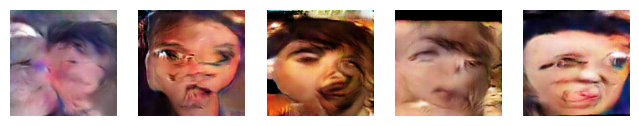

In [30]:
train(dataset, 100,gen_model,discriminator,generator_op,discriminator_op,1)

## Visalization

In [31]:
gen_model.load_weights('gen_99_1.weights.h5')

In [32]:
def generate_images(model, test_input,label):
    labels = tf.repeat(label, [5], axis=None, name=None)
    predictions = model([test_input, labels], training=False)
     
    nrow = 1
    ncol = 5
    fig = plt.figure(figsize=(5,5))
    print("Generated Images are Conditioned on Label:", label_dict[np.array(labels)[0]])
    gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1,1, 1],
         wspace=0.2, hspace=0.2, top=0.2, bottom=0.00, left=0.17, right=0.845) 

    k = 0
    for i in range(nrow):
        for j in range(ncol):
            pred = (predictions[k, :, :, :] + 1 ) * 127.5
            pred = np.array(pred)  
            ax= plt.subplot(gs[i,j])
            ax.imshow(pred.astype(np.uint8))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.axis('off')
            k += 1   

   
    plt.savefig('result.png',  dpi=300)
    plt.show()

In [33]:
num_examples = 5
latent_dim = 100

Generated Images are Conditioned on Label: Ahegao


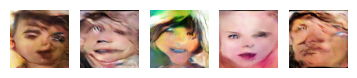

Generated Images are Conditioned on Label: Angry


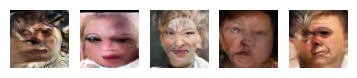

Generated Images are Conditioned on Label: Happy


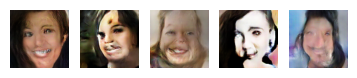

Generated Images are Conditioned on Label: Neutral


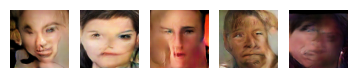

Generated Images are Conditioned on Label: Sad


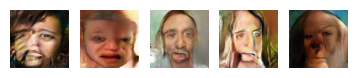

Generated Images are Conditioned on Label: Surprise


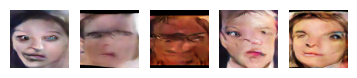

In [34]:
for i in range(6):
    noise = tf.random.normal([num_examples, latent_dim])
    generate_images(gen_model, noise,i)

In [ ]:
## END